## Using presudolabled test data

Using rotated to hz + OpenCv border

Basic default transforms

Using data with wrap instead of border_reflect_101 and imgaug to add classes

Note we dont use aug on irregular metal

valid + predicted test +imgaug per class/10

NB for this run predicted unverified with cutoffs was not used - distribution is very skewed to healthy_metal, 

TODO cf other St Lucia area so see if that has same rook distribution

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
#use imgaug data of equal to class number divided by this
imgaug_divisor = 10

In [5]:
data_dir = Path('data')

In [6]:
RETRAIN = True
RESIZE_IMAGES = True

In [7]:
MODEL_NAME='cv_reflect_imgaug_pseudo_test'

In [8]:
NB_NUM='05_9'

In [9]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 2c904045, DATE: 20191111


In [10]:
#DATE ='20191028'
#UID='77dc216d'

In [11]:
SUB_NUM='18'

In [12]:
img_size=256

In [13]:
### NB we are using pseudo labelled test data for training 

In [14]:
train_images=data_dir/f'train_and_test/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [15]:
test_names = get_image_files(test_images)

In [16]:
assert len(test_names)==7325

In [17]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [18]:
df_all=df_all.drop_duplicates(subset=['id'])

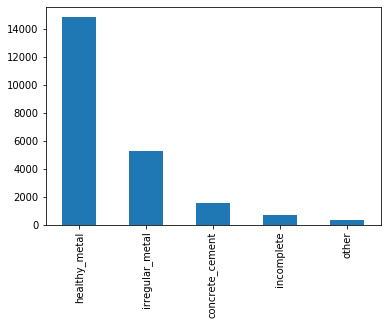

In [19]:
df_all['roof_material'].value_counts().plot(kind='bar')

In [20]:
df_v=df_all.loc[df_all['verified'] == True]

In [21]:
df_v=df_v.drop_duplicates(subset=['id'])

In [22]:
df_v['roof_material'].value_counts()

healthy_metal      7381
irregular_metal    5241
concrete_cement    1387
incomplete          668
other               193
Name: roof_material, dtype: int64

In [23]:
len(df_v)

14870

In [24]:
healthy_metal_frac=7381/14870

In [25]:
healthy_metal_n=7381

In [26]:
irregular_metal_frac=5241/14870

In [27]:
irregular_metal_n=5241

In [28]:
concrete_cement_frac=1387/14870

In [29]:
concrete_cement_n=1387

In [30]:
incomplete_frac=668/14870

In [31]:
incomplete_n=668

In [32]:
other_frac=668/14870

In [33]:
other_n=668

In [34]:
df_npu=pd.read_csv(data_dir/'non_predicted_unverfied.csv')

In [35]:
df_npu=df_npu.drop_duplicates(subset=['id'])

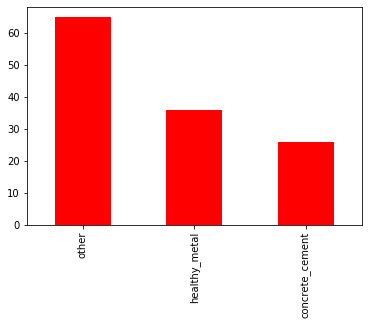

In [36]:
df_npu['roof_material'].value_counts().plot(kind='bar', color='red')

In [37]:
bad_ids=df_npu.id.values.tolist()

In [38]:
df_uv=df_all.loc[df_all['verified'] == False]

In [39]:
df_pred_v=pd.read_csv(data_dir/'pred_invalid_cutoffs-rn50-03_15-cv_reflect_101_valid_cf_verified-20191110-57d55570.csv')

In [40]:
df_pred_v.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,pred,confidence
0,7a24bd7e,0.008806,0.913176,0.002267,0.007207,0.068543,healthy_metal,0.913176
1,7a2cf00c,0.001045,0.994259,0.000526,0.003511,0.000659,healthy_metal,0.994259
2,7a3975e8,0.001082,0.976426,0.000773,0.020468,0.001251,healthy_metal,0.976426
3,7a1d215e,0.000703,0.985209,0.000670,0.002442,0.010977,healthy_metal,0.985209
4,7a42475e,0.014385,0.973137,0.001237,0.008855,0.002385,healthy_metal,0.973137


In [41]:
df_pred_v = df_pred_v.rename(columns={'pred': 'roof_material'})

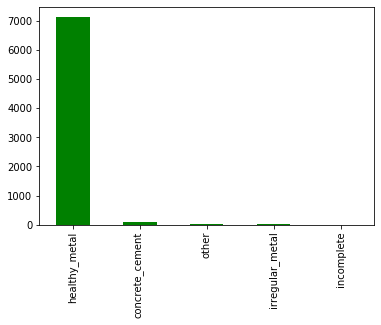

In [42]:
df_pred_v['roof_material'].value_counts().plot(kind='bar', color='green')

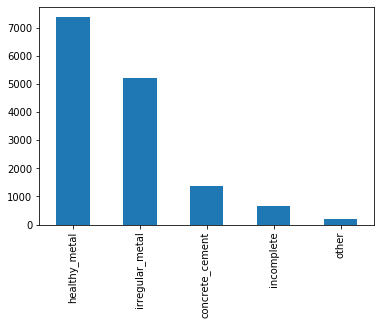

In [43]:
df_v['roof_material'].value_counts().plot(kind='bar')

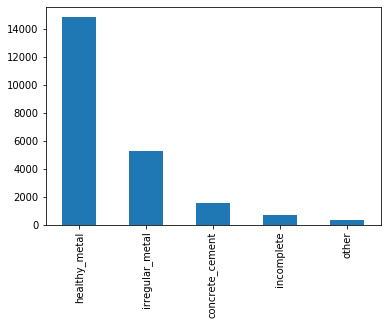

In [44]:
df_all['roof_material'].value_counts().plot(kind='bar')

In [45]:
df_aug=pd.read_csv(data_dir/'df_aug_reflect.csv')

In [46]:
len(df_aug)

171253

In [47]:
df_aug.tail()

,id,roof_material,verified,country,region
171248,7a214bda_imgaug_9_1005,concrete_cement,True,colombia,borde_rural
171249,7a2bfa30_imgaug_7_5683,healthy_metal,True,colombia,borde_soacha
171250,7a3dc152_imgaug_3_1483,healthy_metal,True,colombia,borde_rural
171251,7a3c9b10_imgaug_4_5386,healthy_metal,True,colombia,borde_soacha
171252,7a20854c_imgaug_7_14480,healthy_metal,True,st_lucia,dennery


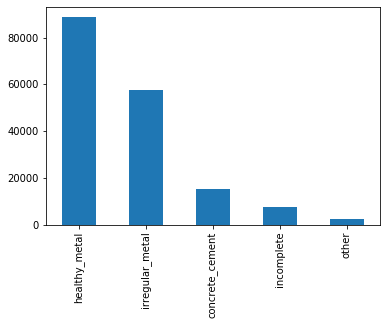

In [48]:
df_aug['roof_material'].value_counts().plot(kind='bar')

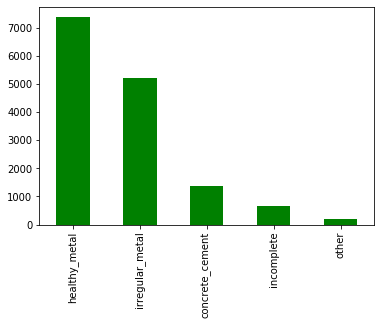

In [49]:
df_v['roof_material'].value_counts().plot(kind='bar', color='green')

In [50]:
df_img=df_aug[df_aug.id.str.contains('imgaug')]

In [51]:
len(df_img)

148700

In [52]:
df_irreg_aug=df_img.loc[df_img['roof_material'] == 'irregular_metal']

In [53]:
df_healthy_aug=df_img.loc[df_img['roof_material'] == 'healthy_metal']

In [54]:
df_concrete_aug=df_img.loc[df_img['roof_material'] == 'concrete_cement']

In [55]:
df_incomplete_aug=df_img.loc[df_img['roof_material'] == 'incomplete']

In [56]:
df_other_aug=df_img.loc[df_img['roof_material'] == 'other']

In [57]:
len(df_irreg_aug)

52410

In [58]:
len(df_healthy_aug)

73810

In [59]:
len(df_concrete_aug)

13870

In [60]:
len(df_incomplete_aug)

6680

In [61]:
len(df_other_aug)

1930

In [62]:
### append a fixed number eg 1000 images to each class

In [63]:
df_irreg_aug = df_irreg_aug.sample(n=int(irregular_metal_n/imgaug_divisor))
df_irreg_aug.head()

,id,roof_material,verified,country,region
51213,7a21f6ac_imgaug_7_8696,irregular_metal,True,colombia,borde_soacha
24046,7a3e414a_imgaug_7_12372,irregular_metal,True,guatemala,mixco_1_and_ebenezer
161907,7a2b2a92_imgaug_4_10592,irregular_metal,True,guatemala,mixco_1_and_ebenezer
155224,7a408248_imgaug_4_7336,irregular_metal,True,colombia,borde_soacha
142369,7a347b88_imgaug_8_5565,irregular_metal,True,colombia,borde_soacha


In [64]:
df_healthy_aug = df_healthy_aug.sample(n=int(healthy_metal_n/imgaug_divisor))
df_healthy_aug.head()

,id,roof_material,verified,country,region
167254,7a41c522_imgaug_6_6564,healthy_metal,True,colombia,borde_soacha
114561,7a40f944_imgaug_0_6831,healthy_metal,True,colombia,borde_soacha
64959,7a1ec180_imgaug_4_11356,healthy_metal,True,guatemala,mixco_1_and_ebenezer
104154,7a3f2484_imgaug_3_11803,healthy_metal,True,guatemala,mixco_1_and_ebenezer
75161,7a268406_imgaug_0_12223,healthy_metal,True,guatemala,mixco_1_and_ebenezer


In [65]:
df_concrete_aug=df_concrete_aug.sample(n=int(concrete_cement_n/imgaug_divisor))
df_concrete_aug.head()

,id,roof_material,verified,country,region
133503,7a2b224a_imgaug_3_10247,concrete_cement,True,colombia,borde_soacha
124236,7a22774e_imgaug_5_10926,concrete_cement,True,guatemala,mixco_1_and_ebenezer
110407,7a2f1d50_imgaug_7_13314,concrete_cement,True,guatemala,mixco_1_and_ebenezer
151015,7a39b288_imgaug_2_12500,concrete_cement,True,guatemala,mixco_1_and_ebenezer
86679,7a3b5fde_imgaug_5_10812,concrete_cement,True,guatemala,mixco_1_and_ebenezer


In [66]:
df_incomplete_aug=df_incomplete_aug.sample(n=int(incomplete_n/imgaug_divisor))
df_incomplete_aug.head()

,id,roof_material,verified,country,region
100857,7a2a9f8c_imgaug_2_5939,incomplete,True,colombia,borde_soacha
31528,7a397728_imgaug_1_6134,incomplete,True,colombia,borde_soacha
41338,7a2c76ae_imgaug_3_7888,incomplete,True,colombia,borde_soacha
56564,7a403d56_imgaug_6_1163,incomplete,True,colombia,borde_rural
102943,7a3cd6ca_imgaug_9_6771,incomplete,True,colombia,borde_soacha


In [67]:
df_v.head()

,id,roof_material,verified,country,region
0,7a3f2a10,concrete_cement,True,colombia,borde_rural
1,7a1f731e,irregular_metal,True,colombia,borde_rural
2,7a424ad8,healthy_metal,True,colombia,borde_rural
3,7a3edc5e,healthy_metal,True,colombia,borde_rural
4,7a303a6e,healthy_metal,True,colombia,borde_rural


In [68]:
df_other_aug=df_other_aug.sample(n=int(other_n/imgaug_divisor))
df_other_aug.head()

,id,roof_material,verified,country,region
120960,7a343d44_imgaug_0_3523,other,True,colombia,borde_rural
36883,7a207fac_imgaug_9_11291,other,True,guatemala,mixco_1_and_ebenezer
35808,7a20b13e_imgaug_8_12275,other,True,guatemala,mixco_1_and_ebenezer
152949,7a37aaec_imgaug_6_11126,other,True,guatemala,mixco_1_and_ebenezer
52036,7a24ac12_imgaug_4_12492,other,True,guatemala,mixco_1_and_ebenezer


#### concat

In [69]:
len(df_v)

14870

In [70]:
frames = [df_irreg_aug, df_healthy_aug, df_concrete_aug, df_incomplete_aug, df_other_aug]

In [71]:
df_all_aug = pd.concat(frames)

In [72]:
df_all_aug = df_v.append(df_all_aug, ignore_index=True)

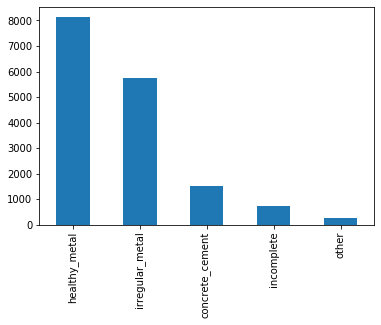

In [73]:
df_all_aug['roof_material'].value_counts().plot(kind='bar')

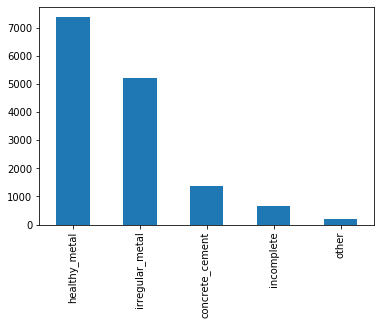

In [74]:
df_v['roof_material'].value_counts().plot(kind='bar')

#### add predicted unverified with confidences

In [75]:
#df_all_aug = df_all_aug.append(df_pred_v, ignore_index=True)

In [76]:
#df_all_aug['roof_material'].value_counts().plot(kind='bar', color='gray')

#### add predicted test with confidences

In [77]:
df_pseudo_lbl_test=pd.read_csv(data_dir/'test_cutoffs-rn50-03_15-cv_reflect_101_valid_cf_verified-20191110-57d55570.csv')

In [78]:
df_pseudo_lbl_test = df_pseudo_lbl_test.rename(columns={'pred': 'roof_material'})

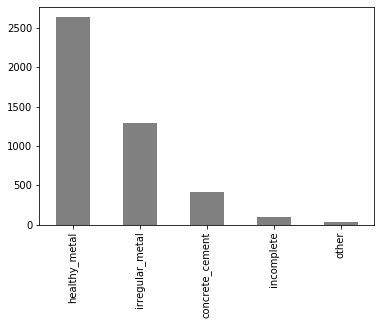

In [79]:
df_pseudo_lbl_test['roof_material'].value_counts().plot(kind='bar', color='gray')

In [80]:
df_all_aug = df_all_aug.append(df_pseudo_lbl_test, ignore_index=True)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


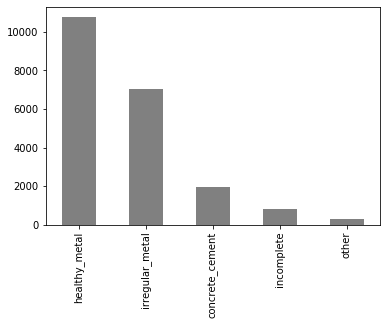

In [81]:
df_all_aug['roof_material'].value_counts().plot(kind='bar', color='gray')

#### test data

In [82]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [83]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [84]:
assert len(df_test)==7325

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [85]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [86]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all_aug, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [87]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [88]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

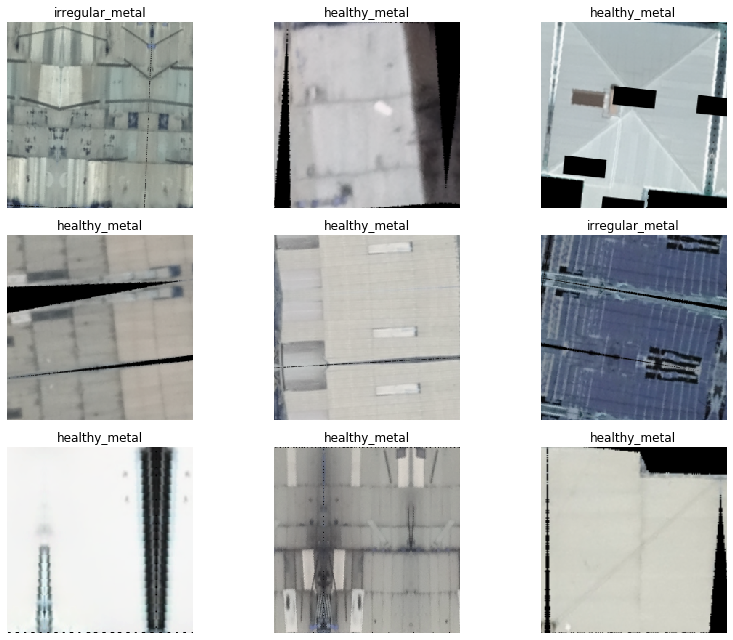

In [89]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [90]:
arch = models.resnet50
arch_name = 'rn50'

In [91]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

### Train model

In [92]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


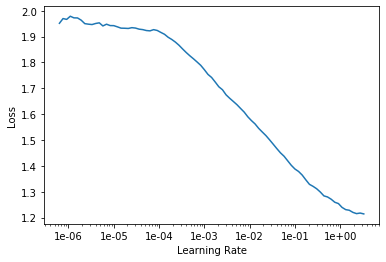

In [93]:
learn.recorder.plot()

Then we can fit the head of our network.

In [94]:
lr = 5e-3

In [95]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.830831,0.664142,0.201342,00:54
1,0.542771,0.489143,0.163950,00:54
2,0.459959,0.435005,0.151486,00:54
3,0.429000,0.416346,0.149569,00:53
4,0.406997,0.413022,0.150288,00:53


In [96]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [97]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (16692 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Valid: LabelList (4172 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,irregular_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train_and_test/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, s

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 228),
 ('healthy_metal', 'irregular_metal', 150),
 ('incomplete', 'irregular_metal', 64),
 ('concrete_cement', 'healthy_metal', 32),
 ('concrete_cement', 'irregular_metal', 23),
 ('incomplete', 'concrete_cement', 17),
 ('incomplete', 'healthy_metal', 17),
 ('healthy_metal', 'concrete_cement', 16),
 ('other', 'healthy_metal', 14),
 ('concrete_cement', 'incomplete', 13),
 ('irregular_metal', 'concrete_cement', 13),
 ('other', 'irregular_metal', 11),
 ('irregular_metal', 'incomplete', 10),
 ('healthy_metal', 'incomplete', 9),
 ('irregular_metal', 'other', 5),
 ('healthy_metal', 'other', 4)]

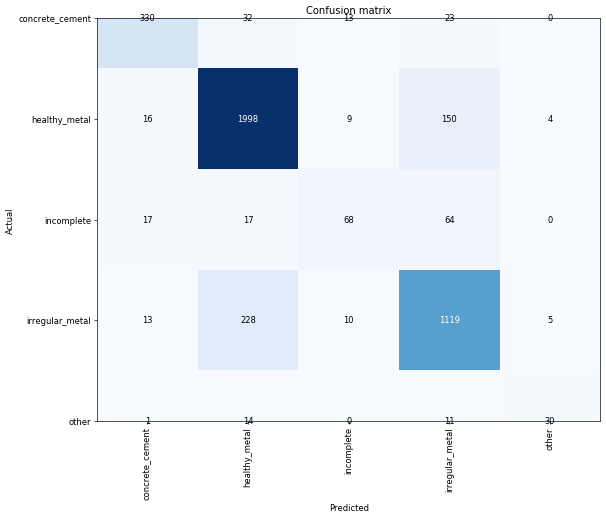

In [99]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [100]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.434651,0.418016,0.149808,00:54
1,0.422069,0.402834,0.143337,00:53
2,0.393730,0.396763,0.145014,00:53
3,0.372524,0.385240,0.140700,00:53
4,0.340240,0.381436,0.138543,00:54


### Re-train

In [101]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


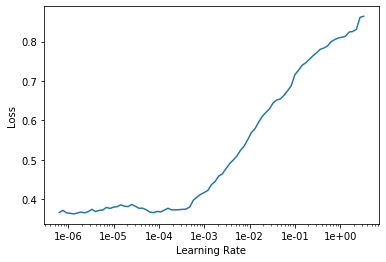

In [102]:
learn.lr_find()
learn.recorder.plot()

In [103]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.393472,0.397311,0.145254,01:07
1,0.396814,0.407163,0.140221,01:07
2,0.370976,0.369834,0.129914,01:06
3,0.292953,0.355649,0.127517,01:08
4,0.249118,0.353152,0.124880,01:06


In [104]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [105]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (16692 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Valid: LabelList (4172 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,irregular_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train_and_test/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, s

In [106]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.276064,0.382271,0.136146,01:07
1,0.332682,0.375819,0.130153,01:07
2,0.281627,0.373275,0.131352,01:07
3,0.224527,0.365857,0.126558,01:07
4,0.179710,0.359421,0.120326,01:07


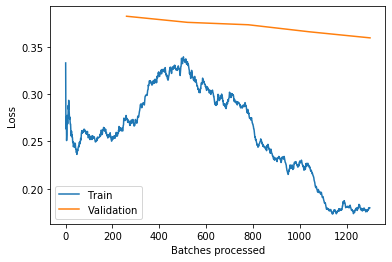

In [107]:
learn.recorder.plot_losses()

In [108]:
learn.save(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### fp32

In [109]:
learn.load(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (16692 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Valid: LabelList (4172 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,irregular_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train_and_test/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train_and_test/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, s

In [110]:
learn = learn.to_fp32()

In [111]:
learn.export(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [112]:
learn.export()

### inference

In [113]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [114]:
len(test_dataset)

7325

In [115]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/reflect/{img_size}', test=test_dataset)

In [116]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [117]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [118]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [119]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [120]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [121]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [122]:
labels = np.argmax(preds, 1)

In [123]:
len(preds)

7325

In [124]:
preds[0].tolist()

[0.013550885021686554,
 0.9738914370536804,
 0.0022063220385462046,
 0.0073822722770273685,
 0.0029692337848246098]

In [125]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [126]:
len(labels)

7325

In [127]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [128]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [129]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [130]:
test_predictions[0]

'healthy_metal'

In [131]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [132]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/reflect/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/reflect/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4d27b4.tif')], dtype=object)

In [133]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [134]:
preds_list[0]

[0.013550885021686554,
 0.9738914370536804,
 0.0022063220385462046,
 0.0073822722770273685,
 0.0029692337848246098]

In [135]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [136]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [137]:
df.head()

,id,pred
0,7a4d9168,"[0.013550885021686554, 0.9738914370536804, 0.0..."
1,7a4ae922,"[0.00651128962635994, 0.9298616051673889, 0.00..."
2,7a48ca98,"[0.016317790374159813, 0.15616460144519806, 0...."
3,7a49c614,"[0.003456693608313799, 0.9416074752807617, 0.0..."
4,7a4dd4f2,"[0.006835892330855131, 0.700330913066864, 0.00..."


In [138]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [139]:
pred_df.insert(loc=0, column='id', value=ids)

In [140]:
pred_df.columns = cols

In [141]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.013551,0.973891,0.002206,0.007382,0.002969
1,7a4ae922,0.006511,0.929862,0.001232,0.059889,0.002506
2,7a48ca98,0.016318,0.156165,0.029898,0.792112,0.005508
3,7a49c614,0.003457,0.941607,0.002747,0.048027,0.004161
4,7a4dd4f2,0.006836,0.700331,0.007340,0.263445,0.022048


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [142]:
pred_ids=pred_df['id'].values.tolist()

In [143]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [144]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [145]:
baseline_ids=df_baseline['id'].values.tolist()

In [146]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [147]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [148]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [149]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.013551,0.973891,0.002206,0.007382,0.002969,7a4d9168
1,7a4ae922,0.006511,0.929862,0.001232,0.059889,0.002506,7a4ae922
2,7a48ca98,0.016318,0.156165,0.029898,0.792112,0.005508,7a48ca98
3,7a49c614,0.003457,0.941607,0.002747,0.048027,0.004161,7a49c614
4,7a4dd4f2,0.006836,0.700331,0.007340,0.263445,0.022048,7a4dd4f2


In [150]:
pred_df=pred_df.sort_values('id_cat')

In [151]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.006790,0.948398,0.004442,0.034373,0.005997,7a4d630a
764,7a4bbbd6,0.002873,0.954727,0.002124,0.038080,0.002195,7a4bbbd6
1841,7a4ac744,0.008112,0.785970,0.005774,0.196487,0.003656,7a4ac744
3363,7a4881fa,0.001710,0.011528,0.027815,0.957231,0.001716,7a4881fa
133,7a4aa4a8,0.010537,0.949475,0.001940,0.036658,0.001390,7a4aa4a8


In [152]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [153]:
assert (len(pred_df))==7325

In [154]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission:

19	0.4654
